In [ ]:
import numpy as np
from collections import deque
from queue import PriorityQueue
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
from math import sqrt
from random import randint

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.4/709.4 kB 11.5 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 154MB/s]


In [ ]:
filenames = [None]*2
images = [None]*2
results = [None]*2

In [ ]:
filenames[0] = input()

Petrus11.png


In [ ]:
filenames[1] = input()

Petrus22.png


In [ ]:
for i in range(2):
  images[i] = cv2.imread(filenames[i])
  resized_image = cv2.resize(images[i], (640, 480))
  cv2.imwrite(filenames[i], resized_image)

In [ ]:
for i in range(2):
  results[i] = model(filenames[i])


image 1/1 /content/Petrus11.png: 480x640 2 persons, 1 tie, 1 chair, 487.4ms
Speed: 47.5ms preprocess, 487.4ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/Petrus22.png: 480x640 2 persons, 1 chair, 1 refrigerator, 331.2ms
Speed: 5.9ms preprocess, 331.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


In [ ]:
#threshold = 30
def calculate_iou(boxA, boxB):
    x1A, y1A, x2A, y2A = map(int,boxA)
    x1B, y1B, x2B, y2B = map(int,boxB)
    xcA, ycA = (x2A - x1A)/2 + x1A, (y2A - y1A)/2 + y1A
    xcB, ycB = (x2B - x1B)/2 + x1B, (y2B - y1B)/2 + y1B
    xA = max(x1A, x1B)
    yA = max(y1A, y1B)
    xB = min(x2A, x2B)
    yB = min(y2A, y2B)
    dist = round(sqrt((xcA - xcB)**2 + (ycA - ycB)**2)) * 10
    intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = intersection_area / (float(boxA_area + boxB_area - intersection_area))
    return iou*10000 / dist
def compare_bounding_boxes(resultA,resultB):
    num_boxes1 = resultA.boxes.shape[0]
    num_boxes2 = resultB.boxes.shape[0]
    n,m = max(num_boxes1, num_boxes2),min(num_boxes2, num_boxes1)
    if n < m:
      resultA, resultB = resultB, resultA
    iou_matrix = np.zeros((n,m))
    for i in range(n):
      boxA = resultA.boxes.xyxy[i]
      confA = resultA.boxes.conf[i]
      classA = resultA.boxes.cls[i]
      if confA < 0.3:
        continue
      for j in range(m):
        boxB = resultB.boxes.xyxy[j]
        confB = resultB.boxes.conf[j]
        classB = resultB.boxes.cls[j]
        if classA != classB:
          continue
        if confB < 0.3:
          continue
        iou = calculate_iou(boxA,boxB)
        print(iou, i, j)
        iou_matrix[i][j] = int(iou)
    return iou_matrix

In [ ]:
def dfs(residual, parent, source, target):
    visited = np.full(len(residual),False)
    stack = deque()
    stack.append(source)
    visited[source] = True
    while stack:
        u = stack.pop()
        for ind, val in enumerate(residual[u]):
            if not visited[ind] and val > 0:
                stack.append(ind)
                visited[ind] = True
                parent[ind] = u
    return visited[target]
def ford_fulkerson(graph):
    n = graph.shape[0]
    parent = np.full(n, -1, dtype=int)
    source = 0
    target = n - 1
    residual = np.copy(graph)
    S = np.array([])
    while dfs(residual, parent, source, target):
        path_flow = np.inf
        s = target
        while s != source:
            path_flow = min(path_flow, residual[parent[s], s])
            s = parent[s]
        v = target
        while v != source:
            u = parent[v]
            if (u == source):
              S = np.append(S,v)
            residual[u, v] -= path_flow
            if (u != source) :
              residual[v, u] += path_flow
            v = parent[v]
    return residual,S
def process(graph):
  n = graph.shape[0]
  G = np.zeros((2*n+2,2*n+2))
  nG = G.shape[0]
  for i in range(1, nG//2):
    G[0][i] = 1
  for i in range(nG//2, nG-1):
    G[i][nG-1] = 1
  for i in range(n):
    for j in range(n):
      if graph[i][j] > 0:
        G[i+1][j + nG//2] = graph[i][j]
      elif graph[i][j] < 0:
        G[i+nG//2][j+1] = -graph[i][j]
  return G
def bfs_sp(graph,source):
    residual = np.copy(graph)
    visited = np.full(len(residual),False)
    visited[source] = True
    queue = deque()
    queue.append(source)
    while queue:
        u = queue.popleft()
        for ind, val in enumerate(residual[u]):
            if not visited[ind] and val > 0 and ind != 0:
                queue.append(ind)
                visited[ind] = True
    return np.array([i for i in range(graph.shape[0]) if visited[i]])
def solution(graph):
  n = graph.shape[0]
  m = graph.shape[1]
  if m != n:
    zeros = np.zeros((n,n - m))
    graph = np.hstack((graph, zeros))
  label_l = np.full(n,0,dtype = int)
  label_r = np.full(n,0,dtype = int)
  for i in range(n):
    label_l[i] = max(graph[i])
  M = np.zeros((n,n))
  for i in range(n):
    for j in range(n):
      if (label_l[i] + label_r[j]) <= graph[i][j]:
        M[i][j] = 1
      elif M[i][j] >= 0 and (label_l[i] + label_r[j]) > graph[i][j]:
        M[i][j] = 0
  return hungarian_algorithm(graph,label_l,label_r,M)
def hungarian_algorithm(graph,label_l,label_r,M):
  n = graph.shape[0]
  #Шаг 1 - заполнить labelы
  #Шаг 2 - заполнить матрицу паросочетания M
  #M = np.zeros((n,n))
  # print("M")
  # print( M )
  for i in range(n):
    for j in range(n):
      if (label_l[i] + label_r[j]) <= graph[i][j]: #and graph[i][j] != 0:
        M[i][j] = 1
      elif M[i][j] >= 0 and (label_l[i] + label_r[j]) > graph[i][j]:
        M[i][j] = 0
  #Шаг 3 - сделать шаг алгоритма: Фордом-Фалкерсоном найти паросочетание
  # print("M")
  # print( M )
  M,Used_vertexes = ford_fulkerson(process(M))
  #Шаг 4 - найти все неиспользованные вершины и bfs-ом прогнать их
  Unused_vertexes = set([i for i in range(1,n+1)])
  Unused_vertexes = Unused_vertexes.difference(Used_vertexes)
  # print("Unused_vertexes", Unused_vertexes)
  temp = set()
  # print("UNV", Unused_vertexes)
  for x in Unused_vertexes:
    temp_from_bfs = np.array(bfs_sp(M,int(x)))
    temp = temp.union(temp_from_bfs)
  # print("temp", temp)
  # print("label_l", label_l)
  # print("label_r", label_r)
  #Шаг 5 - обновить labelы
  for x in temp:
    if x > n:
      #print(x)
      label_r[x-2*n - 1] +=1
    else:
      #print(x)
      label_l[x-1] -=1
  # print("label_l", label_l)
  # print("label_r", label_r)
  sum_of_matching = 0
  matching = M[1:n+1,(n+1):2*n+1] - M[n+1:2*n+1, 1:n+1]
  for i in range(n):
    for j in range(n):
      if matching[i][j] == -1:
        sum_of_matching += graph[i][j]
  # print("sum_of_matching", sum_of_matching)
  # print("matching")
  # print( matching )
  # print("M", M)
  #Шаг 6 - завершить алгоритм, либо продолжить его
  print("-----------------------------------------")
  if (sum(label_l) + sum(label_r) == sum_of_matching):
    max_matching = np.zeros((n,2), dtype = int)
    for i in range(n):
        for j in range(n):
          if matching[i][j] == -1:
              max_matching[i][0] = i+1
              max_matching[i][1] = j+1
  else:
    return hungarian_algorithm(graph,label_l,label_r,matching)
  return max_matching

In [ ]:
compare_bboxes = compare_bounding_boxes(results[0][0],results[1][0])
matching = solution(compare_bboxes)

0.08977720985107294 0 0
5.142630344421157 0 1
4.3422180729847915 1 0
0.0 1 1
26.33873113999263 2 2
-----------------------------------------


In [ ]:
print(matching)

[[1 2]
 [2 1]
 [3 3]
 [4 4]]


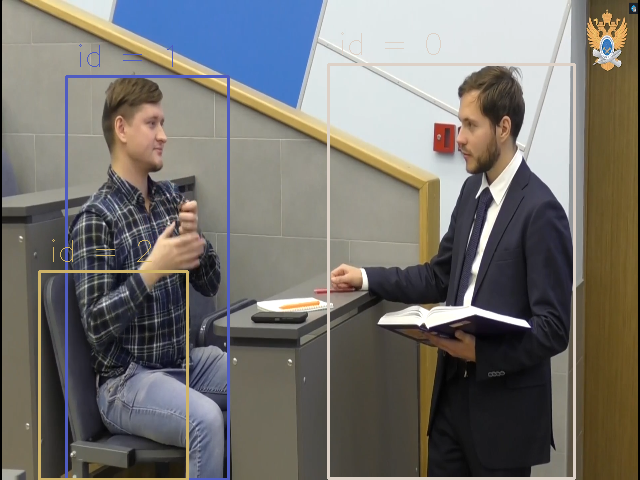

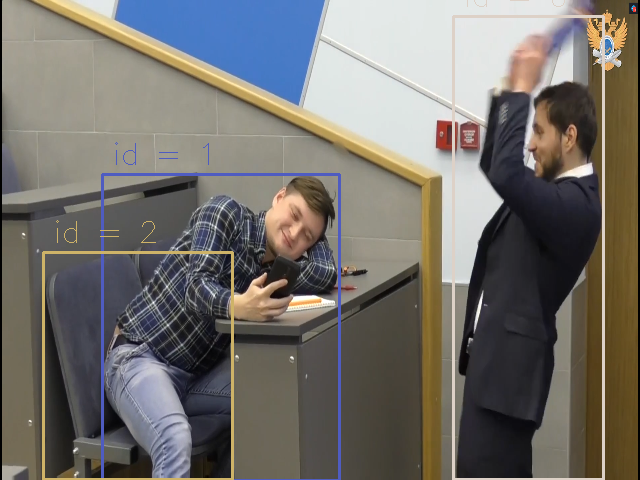

In [ ]:
for i in range(len(matching)):
  if compare_bboxes[matching[i][0]-1][matching[i][1]-1] == 0:
    continue
  bbox = results[0][0].boxes.xyxy
  xyxy = bbox[matching[i][0]-1]
  x1, y1, x2, y2 = map(int,xyxy)
  color = (randint(0,256),randint(0,256),randint(0,256))
  font = cv2.FONT_HERSHEY_SIMPLEX
  fontScale = 1
  cv2.rectangle(images[0], (x1,y1), (x2, y2), color , thickness=2)
  cv2.putText(images[0], f"id = {i}", (x1 + 10, y1 - 10), font, fontScale, color)

  bbox = results[1][0].boxes.xyxy
  xyxy = bbox[matching[i][1]-1]
  x1, y1, x2, y2 = map(int,xyxy)
  cv2.rectangle(images[1], (x1,y1), (x2, y2), color , thickness=2)
  cv2.putText(images[1], f"id = {i}", (x1 + 10, y1 - 10), font, fontScale, color)
cv2_imshow(images[0])
cv2_imshow(images[1])